In [1]:
import os
import random
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestRegressor

path = os.getcwd()
file_path = os.path.join(path,"file")
sub_path = os.path.join(path,"제출")
train_df = pd.read_csv(os.path.join(file_path,"train.csv"))
test_df = pd.read_csv(os.path.join(file_path,"test.csv"))

In [2]:
display(train_df.head())

,ID,timestamp,item,corporation,location,supply(kg),price(원/kg)
0,TG_A_J_20190101,2019-01-01,TG,A,J,0.0,0.0
1,TG_A_J_20190102,2019-01-02,TG,A,J,0.0,0.0
2,TG_A_J_20190103,2019-01-03,TG,A,J,60601.0,1728.0
3,TG_A_J_20190104,2019-01-04,TG,A,J,25000.0,1408.0
4,TG_A_J_20190105,2019-01-05,TG,A,J,32352.0,1250.0


In [3]:
#시계열 특성을 학습에 반영하기 위해 timestamp를 월, 일, 시간으로 나눕니다
train_df['year'] = train_df['timestamp'].apply(lambda x : int(x[0:4]))
train_df['month'] = train_df['timestamp'].apply(lambda x : int(x[5:7]))
train_df['day'] = train_df['timestamp'].apply(lambda x : int(x[8:10]))

test_df['year'] = test_df['timestamp'].apply(lambda x : int(x[0:4]))
test_df['month'] = test_df['timestamp'].apply(lambda x : int(x[5:7]))
test_df['day'] = test_df['timestamp'].apply(lambda x : int(x[8:10]))

In [4]:
from pytimekr import pytimekr
import datetime

List_holiday = []
for i in range(5,1551,7):
    List_holiday.append((datetime.datetime(2019, 1, 1)+datetime.timedelta(i)).strftime("%Y-%m-%d"))
    
for i in range(2019,2024):
    List_holiday.extend(pytimekr.holidays(year=i)) #리스트 형태로 반환

for i in range(len(List_holiday)):
    List_holiday[i] = str(List_holiday[i])
np.sort(List_holiday)

array(['2019-01-01', '2019-01-06', '2019-01-13', '2019-01-20',
       '2019-01-27', '2019-02-03', '2019-02-04', '2019-02-05',
       '2019-02-06', '2019-02-10', '2019-02-17', '2019-02-24',
       '2019-03-01', '2019-03-03', '2019-03-10', '2019-03-17',
       '2019-03-24', '2019-03-31', '2019-04-07', '2019-04-14',
       '2019-04-21', '2019-04-28', '2019-05-05', '2019-05-05',
       '2019-05-12', '2019-05-12', '2019-05-19', '2019-05-26',
       '2019-06-02', '2019-06-06', '2019-06-09', '2019-06-16',
       '2019-06-23', '2019-06-30', '2019-07-07', '2019-07-14',
       '2019-07-21', '2019-07-28', '2019-08-04', '2019-08-11',
       '2019-08-15', '2019-08-18', '2019-08-25', '2019-09-01',
       '2019-09-08', '2019-09-12', '2019-09-13', '2019-09-14',
       '2019-09-15', '2019-09-22', '2019-09-29', '2019-10-03',
       '2019-10-06', '2019-10-09', '2019-10-13', '2019-10-20',
       '2019-10-27', '2019-11-03', '2019-11-10', '2019-11-17',
       '2019-11-24', '2019-12-01', '2019-12-08', '2019-

In [5]:
train_df.loc[train_df['timestamp'].isin(List_holiday)==True,'Holiday']=0
train_df.loc[train_df['timestamp'].isin(List_holiday)==False,'Holiday']=1
test_df.loc[test_df['timestamp'].isin(List_holiday)==True,'Holiday']=0
test_df.loc[test_df['timestamp'].isin(List_holiday)==False,'Holiday']=1

In [6]:
List_i_c_l = []
for i in train_df['item'].unique():
    for j in train_df['corporation'].unique():
        for k in train_df['location'].unique():
            if train_df.loc[(train_df['item']==i) & (train_df['corporation']==j) & (train_df['location']==k) ,:].shape[0]!=0:
                List_i_c_l.append([i,j,k])

In [7]:
def minmaxscaler(data,Min=[],Max=[]):
    if len(Min)==0 and len(Max)==0:
        return (data-np.min(data,axis=0))/(np.max(data,axis=0)-np.min(data,axis=0)), np.min(data,axis=0),np.max(data,axis=0)
    else:
        return (data-Min)/(Max-Min)

In [8]:
a = test_df['ID'].str.split("_")
I = ""
J = ""
K = ""
List_Test = []
for i,j,k,l in a:
    if I!=i or J!=j or K!=k:
        List_Test.append([i,j,k])
        I = i
        J = j
        K = k
    else:
        continue

In [9]:
for i, j, k in List_i_c_l:
    globals()[f"train_{i}_{j}_{k}"] = train_df.loc[(train_df['item']==i) & (train_df['corporation']==j) & (train_df['location']==k) ,:]
    globals()[f"train_x_{i}_{j}_{k}"] = globals()[f"train_{i}_{j}_{k}"].drop(columns=['ID', 'timestamp', 'item', 'corporation','location', 'supply(kg)', 'price(원/kg)'])
    globals()[f'train_y_{i}_{j}_{k}'] = globals()[f"train_{i}_{j}_{k}"]['price(원/kg)']    
    globals()[f're_train_x_{i}_{j}_{k}'],globals()[f'Min_train_{i}_{j}_{k}'],globals()[f'Max_train_{i}_{j}_{k}'] = minmaxscaler(globals()[f"train_x_{i}_{j}_{k}"])
    
    globals()[f"test_{i}_{j}_{k}"] = test_df.loc[(test_df['item']==i) & (test_df['corporation']==j) & (test_df['location']==k) ,:]
    globals()[f"test_x_{i}_{j}_{k}"] = globals()[f"test_{i}_{j}_{k}"].drop(columns=['ID', 'timestamp', 'item', 'corporation','location'])
    globals()[f're_test_x_{i}_{j}_{k}'] = minmaxscaler(globals()[f"test_x_{i}_{j}_{k}"] ,globals()[f'Min_train_{i}_{j}_{k}'],globals()[f'Max_train_{i}_{j}_{k}'])
    
    globals()[f"model_{i}_{j}_{k}"] = LGBMRegressor(random_state=0, max_depth=16, learning_rate=0.01,is_training_metric=True
                          , subsample=0.8, n_estimators=3000,objective='regression',metric='RMSE')
    globals()[f"model_{i}_{j}_{k}"].fit(globals()[f"re_train_x_{i}_{j}_{k}"], globals()[f'train_y_{i}_{j}_{k}'])
    
    globals()[f'preds_{i}_{j}_{k}'] = globals()[f"model_{i}_{j}_{k}"].predict(globals()[f're_test_x_{i}_{j}_{k}'])
    globals()[f'preds_{i}_{j}_{k}'][np.where((globals()[f'preds_{i}_{j}_{k}'] < 0))[0]] = 0
    globals()[f'preds_{i}_{j}_{k}']

In [10]:
preds = np.zeros((0,1))
for i, j, k in List_Test:
    preds = np.vstack((preds, np.expand_dims(globals()[f'preds_{i}_{j}_{k}'],axis = -1))) 

In [11]:
preds.shape

(1092, 1)

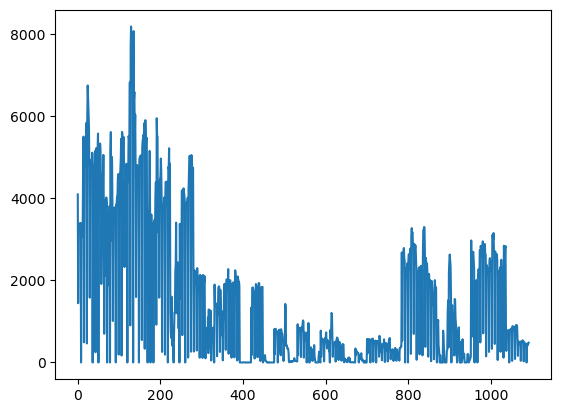

In [12]:
import matplotlib.pyplot as plt
plt.plot(preds)
plt.show()

In [13]:
submission = pd.read_csv(os.path.join(file_path,"sample_submission.csv"))
submission

,ID,answer
0,TG_A_J_20230304,0
1,TG_A_J_20230305,0
2,TG_A_J_20230306,0
3,TG_A_J_20230307,0
4,TG_A_J_20230308,0
...,...,...
1087,RD_F_J_20230327,0
1088,RD_F_J_20230328,0
1089,RD_F_J_20230329,0
1090,RD_F_J_20230330,0


In [14]:
holiday_test = ["20230305","20230312","20230319","20230326"]
submission['answer'] = preds
submission.loc[submission['ID'].str.split("_").str[3].isin(holiday_test),"answer"] = 0
submission

,ID,answer
0,TG_A_J_20230304,4092.590891
1,TG_A_J_20230305,0.000000
2,TG_A_J_20230306,3397.997924
3,TG_A_J_20230307,3297.739303
4,TG_A_J_20230308,3240.762333
...,...,...
1087,RD_F_J_20230327,458.138834
1088,RD_F_J_20230328,440.767798
1089,RD_F_J_20230329,418.584379
1090,RD_F_J_20230330,473.179191


In [15]:
submission.to_csv(os.path.join(sub_path,"baseline_submission24.csv"), index=False)